<a href="https://colab.research.google.com/github/SAMIJAI/-Sketch2Color-anime-translation/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading kaggle data:

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ktaebum/anime-sketch-colorization-pair

100% 11.6G/11.6G [04:41<00:00, 36.3MB/s]



In [ ]:
"""
Extracting the data from compressed zip file.
"""
Archive('./anime-sketch-colorization-pair.zip').extractall('.')

## 1. Importing libraries and data:

In [ ]:
!pip install pyunpack

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import save_model, load_model
import matplotlib.pyplot as plt
from pyunpack import Archive
import urllib.request
from PIL import Image
from tqdm import tqdm 
import numpy as np
import glob

  Created wheel for pyunpack: filename=pyunpack-0.1.2-cp36-none-any.whl size=5162 sha256=02f54d0dfd9192e08da5c02b788d2bf7984f6dcd6ebd67c9707c9ee7f5a34e95
  Stored in directory: /root/.cache/pip/wheels/af/44/08/60613970881e542c0baad1f2dea5ed8e6716bc573f49197b7e
Successfully built pyunpack


In [ ]:
"""
Getting access to the google drive in colab for the dataset. 
"""
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
"""
Extracting the data from compressed zip file.
"""
Archive('drive/My Drive/Sketch2Image/AnimeTestData.zip').extractall('.')

## 2. Utils:

In [ ]:
def final_model(path):
  """
  A function to load the keras model from the given path.

  Parameters:
    path (string): The absolute path to the model to be loaded.

  Returns:
    keras.Model: The loaded keras model. 
  """

  return load_model(path)

def predict(test_skets, generator):
  """
  A function for predicting colors of input sketches using trained generator.

  Parameters:
    test_skets (numpy.array): The black-and-white sketches.
    generator (keras.Model): A trained generator model.
  """

  pred = generator.predict(test_skets)

  # Rescaling the generated color images and input sketches to the range [0, 255].
  pred = (pred+1)/2.0
  test_skets = (test_skets+1)/2.0

  # Displaying the generated color images from the generator.
  f, a = plt.subplots(test_skets.shape[0], 2,\
                      figsize=(.8 * test_skets.shape[0],\
                               5 * test_skets.shape[0]))
  a = a.flatten()
  idx = 0
  
  for sket, pic in zip(test_skets, pred):
    a[idx].imshow(sket); a[idx].axis('off')
    a[idx+1].imshow(pic); a[idx+1].axis('off')
    idx += 2

  plt.subplots_adjust(wspace=.1, hspace=.1)
  plt.show()

## 3. Generating the colored images for images not used in training and validation:

In [ ]:
"""
Generating the paths for the black-and-white sketches.
"""
sketch_paths = glob.glob('Sketches/*.png')

sketch_paths = np.array(sketch_paths)

"""
Loading the random `K` test sketches into the memory.
"""
sketches = []

for sket in sketch_paths:
    sketches.append(np.array(Image.open(sket).convert('RGB')))

sketches = (np.array(sketches, dtype='float32')-127.5)/127.5

In [ ]:
generator = final_model(path='drive/My Drive/Sketch2Image/BestModels/generator_model_043.h5')

### Epoch 43 generator model on test sketches:

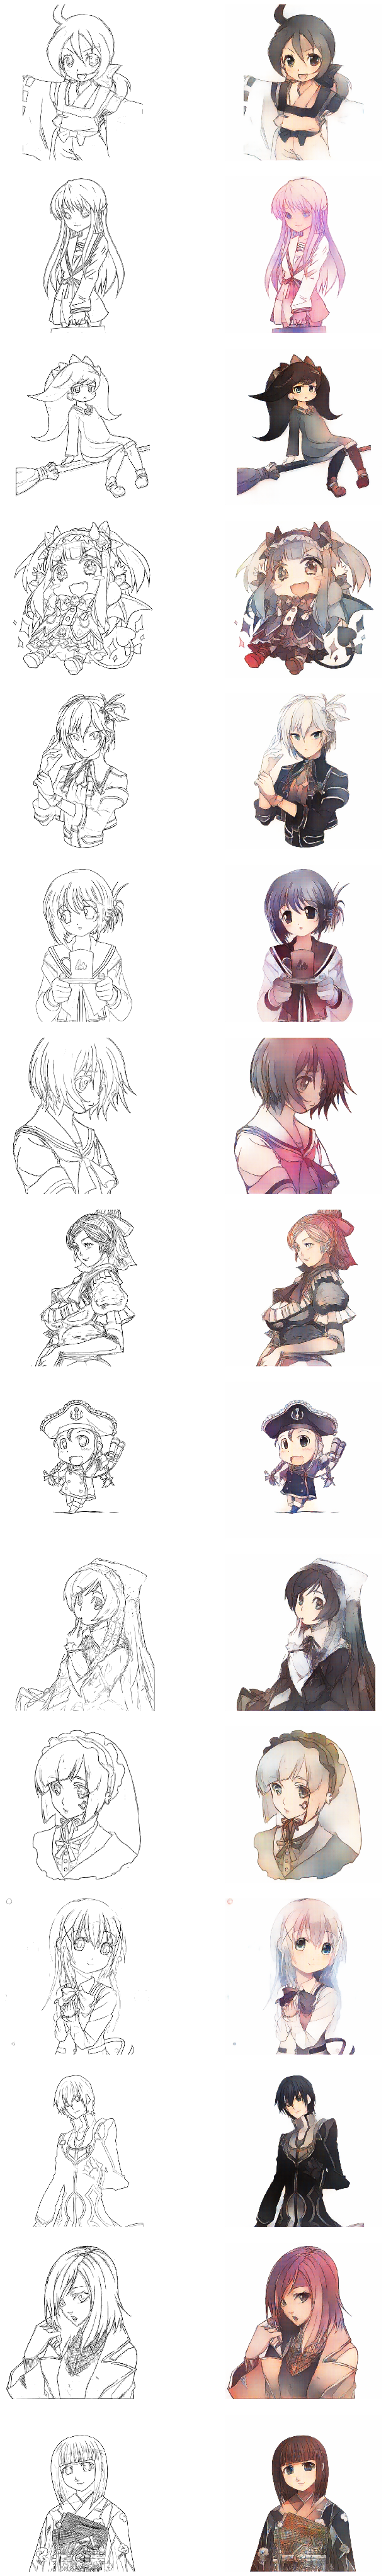

In [ ]:
predict(sketches, generator)

### Epoch 34 generator model on test sketches:

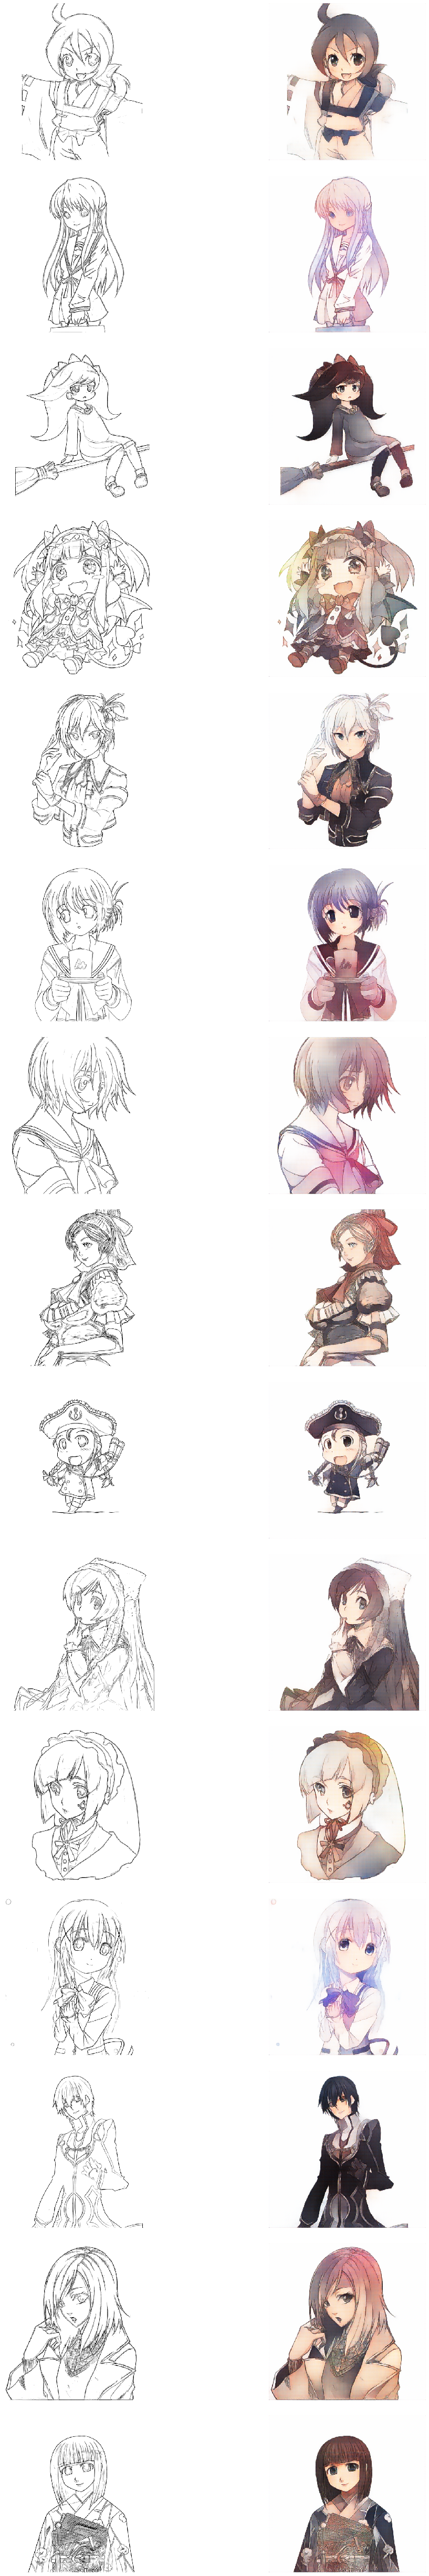

In [ ]:
generator = final_model(path='drive/My Drive/Sketch2Image/BestModels/generator_model_034.h5')

predict(sketches, generator)

## Pixel-wise accuracy and entropy on test sketches:

In [ ]:
!mkdir Images
!mkdir Sketches

In [ ]:
def pixelwise_accuracy(img_real, img_fake, thresh):
    """
    Calulates the per-pixel accuracy of target colored and generated color image.

    Parameters:
      img_real (numpy.array): The target color image. 
      img_fake (numpy.array): The generated color image.
      thresh (float): The threshold for the generated value to less than or equal.

    Returns:
      float: The pixel-wise accuracy between generated and target images.
    """
    img_real = (img_real + 1) / 2.
    img_fake = (img_fake + 1) / 2.

    diffR = np.absolute(np.round(img_real[..., 0]) - np.round(img_fake[..., 0]))
    diffG = np.absolute(np.round(img_real[..., 1]) - np.round(img_fake[..., 1]))
    diffB = np.absolute(np.round(img_real[..., 2]) - np.round(img_fake[..., 2]))

    # Check if the values lie within a threshold.
    predR = np.less_equal(diffR, 1 * thresh)
    predG = np.less_equal(diffG, 1 * thresh)
    predB = np.less_equal(diffB, 1 * thresh)

    # Mutilplying values across the channels.
    pred = predR * predG * predB

    return np.mean(pred)

# https://www.jeremyjordan.me/semantic-segmentation/
def pixelwise_entropy(img_real, img_fake):
    """
    Calulates the per-pixel entropy between target colored and generator colored image.

    Parameters:
      img_real (numpy.array): The target color image. 
      img_fake (numpy.array): The generated color image.

    Returns:
      float: The pixel-wise entropy between generated and target images.
    """
    img_real = (img_real + 1) / 2. 
    img_real /= 255.
    
    img_fake = (img_fake + 1) / 2.
    img_fake /= 255.

    target = np.less_equal(img_real, .5).astype(np.int)
    pred = - np.log(img_fake)

    channel_wise_entropy = np.mean(target * pred, axis=2)
    
    return np.mean(channel_wise_entropy)

In [ ]:
"""
Loading the generator model.
"""
g_model = final_model(path='drive/My Drive/Sketch2Image/BestModels/generator_model_043.h5')

"""
Generating the paths for test sketches.
"""
test_paths = np.array(glob.glob('data/val/*.png'))

In [ ]:
!rm -r Images/*
!rm -r Sketches/*

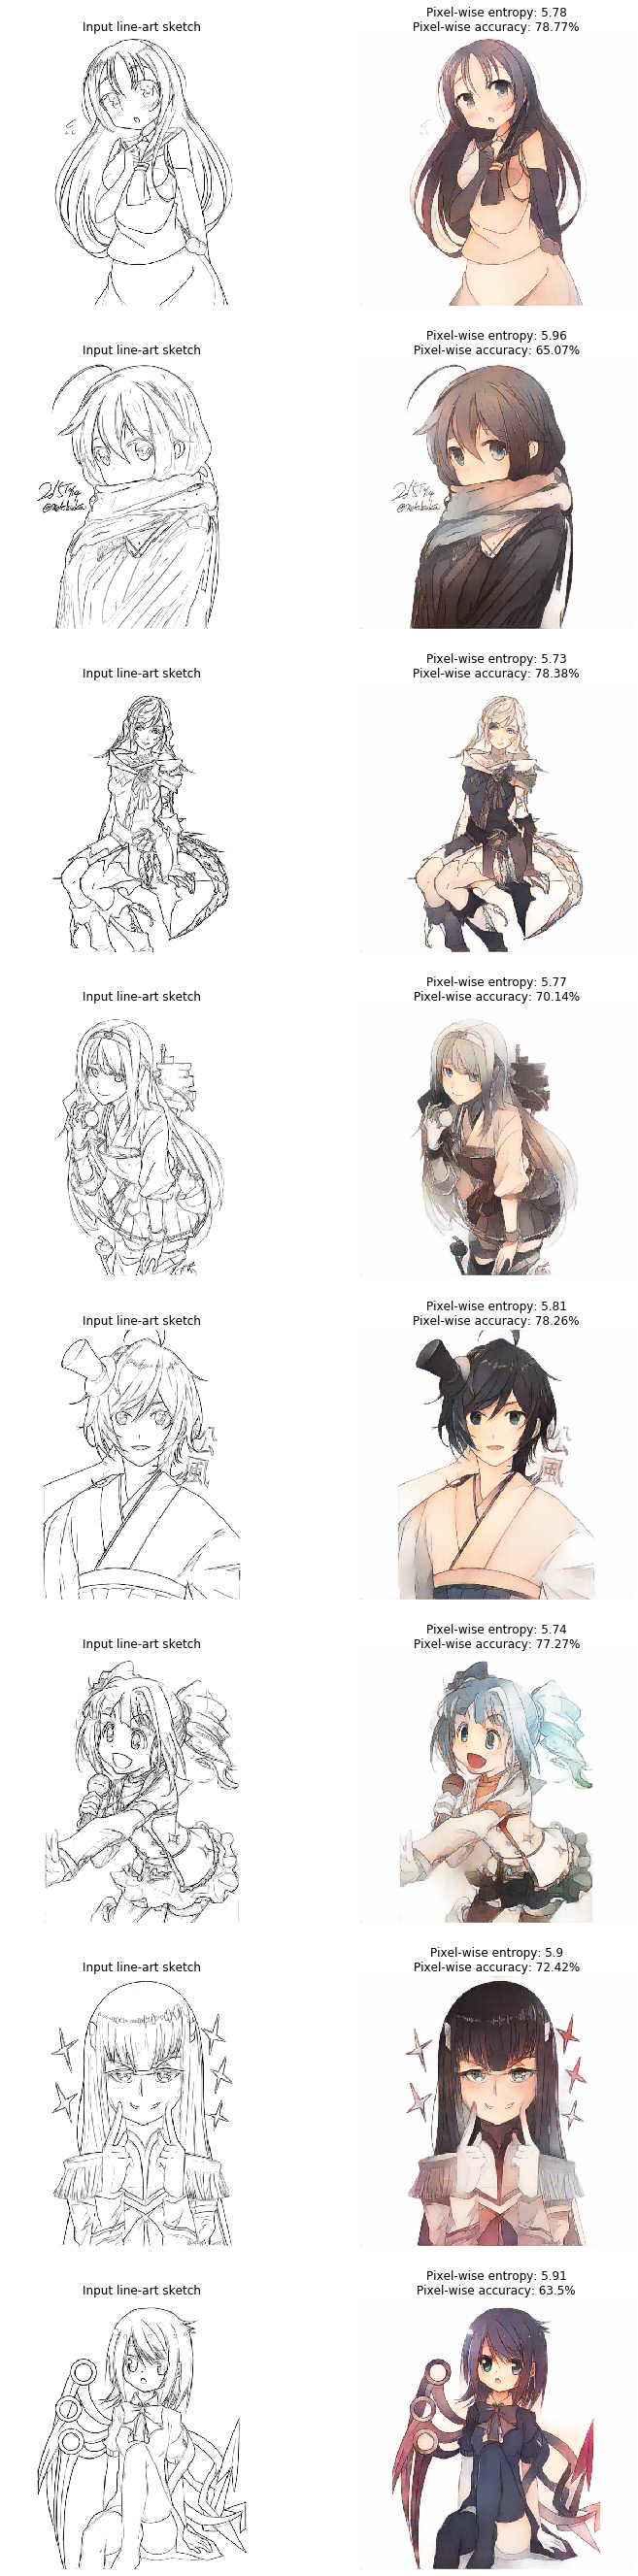

In [ ]:
"""
Preprocessing and saving the data to corresponding directory. 
"""
for idx, file in enumerate(test_paths[np.random.randint(0, test_paths.shape[0], 15)]):
    img = Image.open(file).convert('RGB')
    
    img.crop((0, 0, 512,512)).save('Images/{}.png'.format(idx))
    img.crop((512, 0, 1024, 512)).save('Sketches/{}.png'.format(idx))


"""
Generating the paths for the black-and-white sketches.
"""
sketch_paths = glob.glob('Sketches/*.png')
img_paths = glob.glob('Images/*.png')

sketch_paths.sort()
img_paths.sort()

sketch_paths = np.array(sketch_paths)
img_paths = np.array(img_paths)

"""
Loading the random `K` test sketches into the memory.
"""
sketches = []
imgs = []

for sket, img in zip(sketch_paths, img_paths):
    sketches.append(np.array(Image.open(sket).convert('RGB')))
    imgs.append(np.array(Image.open(img).convert('RGB')))

# Rescaling the generated color images and input sketches to the range [0, 255].
sketches = (np.array(sketches, dtype='float32')-127.5)/127.5
imgs = (np.array(imgs, dtype='float32')-127.5)/127.5

# Predicting the colors for the line-art anime.
gene_imgs = g_model.predict(sketches)

# Displaying the generated color images from the generator.
fig, axes = plt.subplots(sketches.shape[0], 2, figsize=(1.5 * sketches.shape[0], 6 * sketches.shape[0])); 
axes = axes.flatten(); # figsize ~ 23, 15

idx = 0 
for ind, (sk, im) in enumerate(zip(sketches, gene_imgs)):
  axes[idx].imshow( (sk + 1) / 2.)
  axes[idx].set_title('Input line-art sketch')
  axes[idx].axis('off')

  axes[idx+1].imshow( (im + 1) / 2.)
  axes[idx+1].set_title('\n'.join(['Pixel-wise entropy: {}'.format(np.round(pixelwise_entropy(imgs[ind], im), 2)),\
                          'Pixel-wise accuracy: {}%'.format(np.round(pixelwise_accuracy(imgs[ind], im, 0.05)*100., 2))]))
  axes[idx+1].axis('off')

  idx += 2
  
plt.subplots_adjust(wspace=.2, hspace=.2)
plt.show()